# 4. Sales Prediction Model

## 4.1 Contents<a id='4.1'></a>
* [4.1 Contents](#4.1)
* [4.2 Introduction ](#4.2)
* [4.3 Imports ](#4.3)
* [4.4 Load Data & Set Options](#4.4)
* [4.5 Baseline XGBoost Model & Analysis of the Residuals](#4.4)
* [4.6 XGBoost model on 0.25 IQR Subset of the Data ](#4.6)
    * [4.6.1 Run Selected Model on Entire Data Set ](#4.6.1)
* [4.7 SHAP Analysis ](#4.7)
* [4.8 Conclusions ](#4.8)
* [4.9 Next Steps ](#4.9)
* [4.10 Export Model ](#4.10)

## 4.2 Introduction <a id='4.2'></a>

In the last notebook, I added coupon redemption rate as a feature, and ran two baseline models: an XGBoost regression model to predict weekly sales per household, and an XGBoost classification model to predict if a customer will use coupons or not. 

There was significant overfitting in both models. For the regression model, I know that I need to choose a narrower subset of the data to eliminate outliers, and it is unlikely that I will develop a model that can be helpful for predicting actual sales values; however, the error is small enough so that I should be able to determine how features contribute towards the directionality of sales, so I will use SHAP to do this. 

For the classification model, I need to better address the imbalanced class issue, and I will do so with both oversampling and undersampling. I will compare the results of both sampling methods along with my base model, and select the resampling method that works best. I hope that I can develop a useful model to predict which customers will use coupons, but I will also do SHAP analysis so that I can determine how the features contribute towards coupon use. 

## 4.3 Imports <a id='4.3'></a>

In [1]:
# Basic Packages and Data Manipulation
import pandas as pd
import numpy as np
from pandasql import sqldf
import pandasql as psql
import random

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning: Preprocessing, Models, and Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, recall_score, r2_score
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.pipeline import make_pipeline 
import shap
from sklearn.model_selection import GridSearchCV

import pickle

## 4.4 Load <a id='4.4'></a>

In [2]:
data = pd.read_csv(r"C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\Capstone 3\exports\exports_2\data.csv")

### Set Options

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# Load JS visualization code to notebook 
shap.initjs()

## 4.5 Baseline XGBoost Model & Analysis of the Residuals <a id='4.5'></a>

Continuing from the last notebook, it is now time to run a baseline XGBoost Model. I know that there is high error, so I will be looking at the residuals and extracting a subset of the interquartile range, so that I can build a model that isn't impacted by the outliers.

In [4]:
# Inspect the dataframe I am using
data.head()

,household_key,week_no,total_sales_value,redemption_rate,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_Married,marital_status_Single,marital_status_Unknown,income_desc_100-124K,income_desc_125-149K,income_desc_15-24K,income_desc_150-174K,income_desc_175-199K,income_desc_200-249K,income_desc_25-34K,income_desc_250K+,income_desc_35-49K,income_desc_50-74K,income_desc_75-99K,income_desc_Under 15K,homeowner_desc_Homeowner,homeowner_desc_Probable Owner,homeowner_desc_Probable Renter,homeowner_desc_Renter,homeowner_desc_Unknown,hh_comp_desc_1 Adult Kids,hh_comp_desc_2 Adults Kids,hh_comp_desc_2 Adults No Kids,hh_comp_desc_Single Female,hh_comp_desc_Single Male,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
0,1,33,123.86,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
1,1,34,42.80,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
2,1,36,80.45,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
3,1,38,72.82,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
4,1,40,113.07,0.755287,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True


<b> Baseline Model: XG Boost </b>

Regression model, where the total sales value is the target feature. 

In [5]:
# Drop the columns I don't want here, including the target
X = data.drop(columns= ['household_key', 'week_no', 'total_sales_value'], axis=1)  
y = data['total_sales_value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [6]:
base_model = XGBRegressor()

base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)

rmse_base = np.sqrt(mean_squared_error(y_test, y_pred))
mae_base = mean_absolute_error(y_test, y_pred)

print('RMSE: ',rmse_base)
print('MAE: ', mae_base)

# Perform cross-validation
scores = cross_val_score(base_model, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the mean and standard deviation of the scores
print(f'Mean CV MAE : {scores.mean()}')
print(f'Standard Deviation of CV MAE: {scores.std()}')

RMSE:  59.052343961256156
MAE:  42.45571076399534
Mean CV MAE : -55.04143901385005
Standard Deviation of CV MAE: 2.5705599403262873


<b> Plot residuals  & IQR for different multipliers</b>

I have the base XGBoost model, and I'd like to see a histogram of the residuals. I am also including verticle lines to show the ranges for different multipliers of the IQR. 

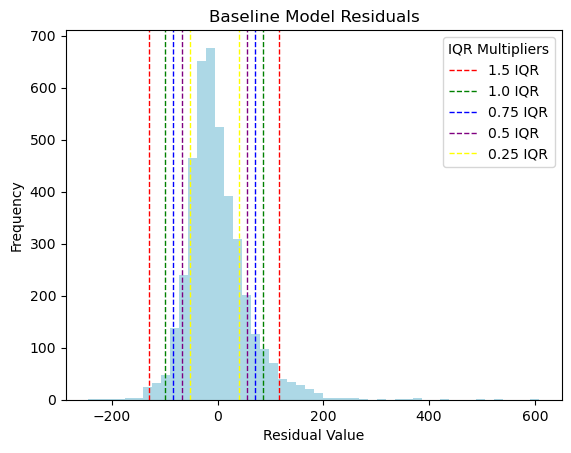

In [7]:
# Baseline residuals in our original model
residuals_base = y_test - y_pred

# Calculate Q1, Q3, and IQR
Q1 = np.percentile(residuals_base, 25)
Q3 = np.percentile(residuals_base, 75)
IQR = Q3 - Q1

# Define IQR multipliers
iqr_multipliers = [1.5, 1.0, 0.75, 0.5, 0.25]
colors = ['red', 'green', 'blue', 'purple', 'yellow']

# Plot histogram
plt.hist(residuals_base, bins=50, color='lightblue') 
plt.title('Baseline Model Residuals')
plt.xlabel("Residual Value")
plt.ylabel("Frequency")

# To avoid duplicate legend entries
added_multipliers = set()

# Add vertical lines based on IQR multipliers
for multiplier, color in zip(iqr_multipliers, colors):
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    label = None
    if multiplier not in added_multipliers:
        label = f'{multiplier} IQR'
        added_multipliers.add(multiplier)
        
    plt.axvline(x=lower_bound, color=color, linestyle='--', linewidth=1, label=label)
    plt.axvline(x=upper_bound, color=color, linestyle='--', linewidth=1)

plt.legend(title='IQR Multipliers')
plt.show();


Above I can see that the 0.25 IQR range eliminates most of the outliers. 

Now look at the actual vs predicted plot. 

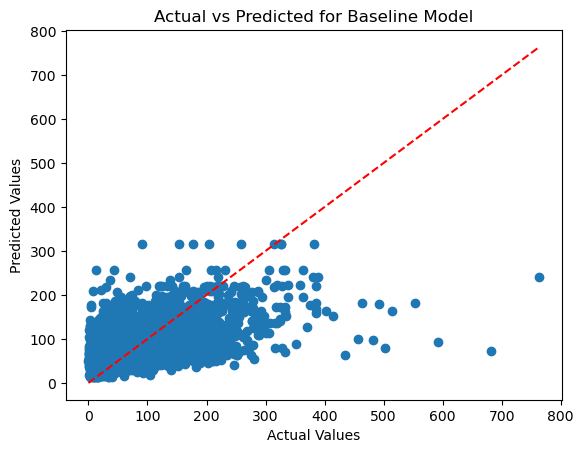

In [8]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs Predicted for Baseline Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


Unfortunately, there is not a linear relationship for actual vs predicted values for the XGBoost base model. This model is not a good fit so far. 

Now plot the actual vs residuals. 

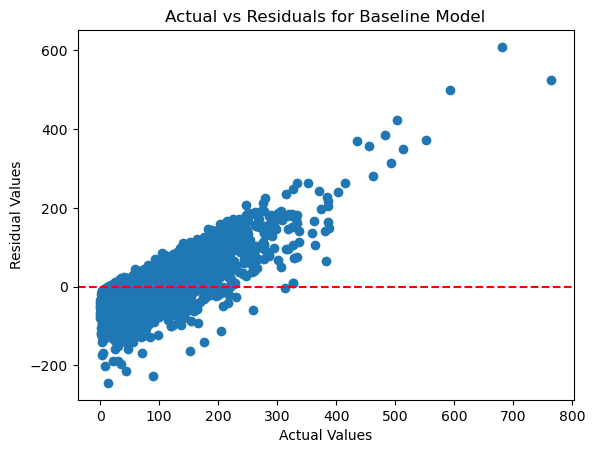

In [9]:
plt.scatter(y_test, residuals_base)
plt.axhline(y=0, color='r', linestyle='--') 
plt.title('Actual vs Residuals for Baseline Model')
plt.xlabel('Actual Values')
plt.ylabel('Residual Values')
plt.show()

The actual vs residuals model is especially interesting, this seems to follow a linear trend, but ideally it would be flat. As the actual values increase, the residuals increase. 

I'd like to see if things improve if I remove outliers using IQR.

<b> Make some new dataframes with different IQR multipiers</b>

In [10]:
# Define rangeS
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

#IQR = 1
lower_bound_1 = Q1 - 1.0 * IQR 
upper_bound_1= Q3 + 1.0 * IQR

#IQR = 1.5
lower_bound_15 = Q1 - 1.5 * IQR 
upper_bound_15= Q3 + 1.5 * IQR

#IQR = 0.75
lower_bound_075 = Q1 - 0.75 * IQR 
upper_bound_075= Q3 + 0.75 * IQR

#IQR = 0.5
lower_bound_05 = Q1 - 0.5 * IQR 
upper_bound_05= Q3 + 0.5 * IQR

#IQR = 0.25
lower_bound_25 = Q1 - 0.25 * IQR 
upper_bound_25= Q3 + 0.25 * IQR


In [11]:
IQR_15_data = data[(data['total_sales_value'] >= lower_bound_15) & (data['total_sales_value'] <= upper_bound_15)]
IQR_1_data = data[(data['total_sales_value'] >= lower_bound_1) & (data['total_sales_value'] <= upper_bound_1)]
IQR_075_data = data[(data['total_sales_value'] >= lower_bound_075) & (data['total_sales_value'] <= upper_bound_075)]
IQR_05_data = data[(data['total_sales_value'] >= lower_bound_05) & (data['total_sales_value'] <= upper_bound_05)]
IQR_025_data = data[(data['total_sales_value'] >= lower_bound_25) & (data['total_sales_value'] <= upper_bound_25)]

<b> Make a function that runs the model, adds to the above plots, and stores the error metrics </b>

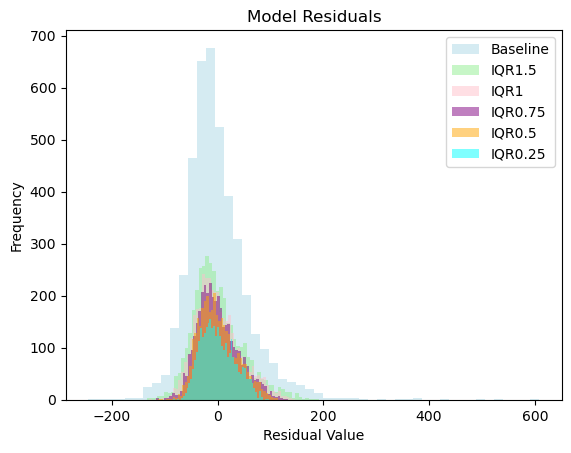

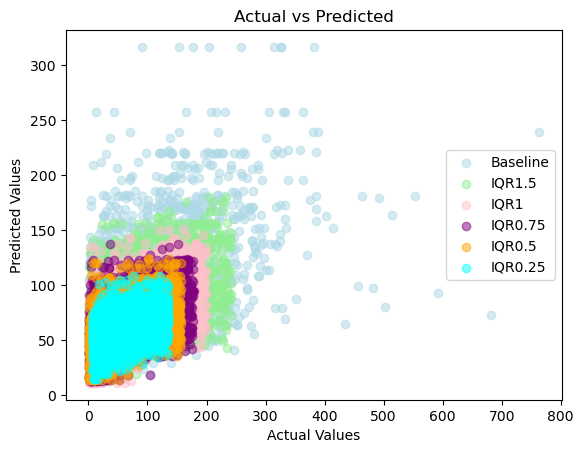

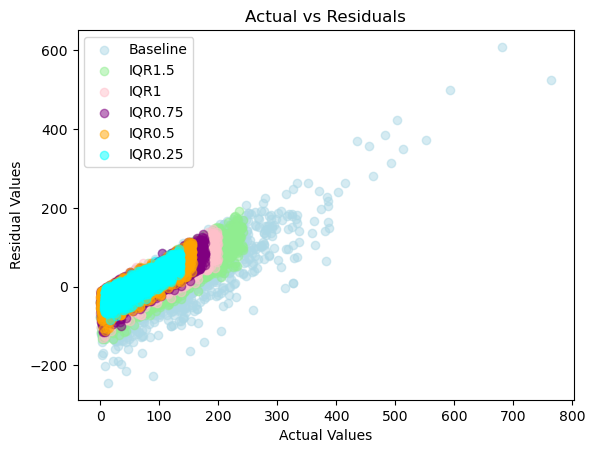

    Variant       RMSE        MAE
0  Baseline  59.052344  42.455711
1    IQR1.5  47.241592  36.818786
2      IQR1  42.466066  33.635008
3   IQR0.75  38.376772  30.602358
4    IQR0.5  36.233430  29.286820
5   IQR0.25  31.650459  26.069642


In [12]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()

# store metrics here
metrics = pd.DataFrame(columns=['Variant', 'RMSE', 'MAE'])

# Pre-defined colors
colors = ['lightblue', 'lightgreen', 'pink', 'purple', 'orange', 'cyan', 'yellow']

def run_model_variant(data, variant_name, cols_to_drop, target_col, test_size=0.1, random_state=42, color_idx=0):
    global metrics
    
    # Drop specified columns and define target
    X = data.drop(columns=cols_to_drop, axis=1)
    y = data[target_col]
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Train model
    model = XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Store the metrics in the DataFrame
    metrics = pd.concat([metrics, pd.DataFrame([{'Variant': variant_name, 'RMSE': rmse, 'MAE': mae}])], ignore_index=True)

    # Generate a distinct color from the list
    color = colors[color_idx % len(colors)]
    
    # Plotting
    ax1.hist(residuals, bins=50, alpha=0.5, label=f"{variant_name}", color=color)
    ax1.set_title('Model Residuals')
    ax1.set_xlabel("Residual Value")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    
    ax2.scatter(y_test, y_pred, alpha=0.5, label=f"{variant_name}", color=color)
    ax2.set_title('Actual vs Predicted')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    ax2.legend()
    
    ax3.scatter(y_test, residuals, alpha=0.5, label=f"{variant_name}", color=color)
    ax3.set_title('Actual vs Residuals')
    ax3.set_xlabel('Actual Values')
    ax3.set_ylabel('Residual Values')
    ax3.legend()

    return rmse, mae

cols_to_drop = ['household_key', 'week_no', 'total_sales_value']
target_col = 'total_sales_value'

# Initialize color index
color_idx = 0

# Running the models
rmse_base, mae_base = run_model_variant(data, "Baseline", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR15, mae_IQR15 = run_model_variant(IQR_15_data, "IQR1.5", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR1, mae_IQR1 = run_model_variant(IQR_1_data, "IQR1", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR075, mae_IQR075 = run_model_variant(IQR_075_data, "IQR0.75", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1  

rmse_IQR05, mae_IQR05 = run_model_variant(IQR_05_data, "IQR0.5", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1

rmse_IQR025, mae_IQR025 = run_model_variant(IQR_025_data, "IQR0.25", cols_to_drop, target_col, color_idx=color_idx)
color_idx += 1

plt.show()

print(metrics)

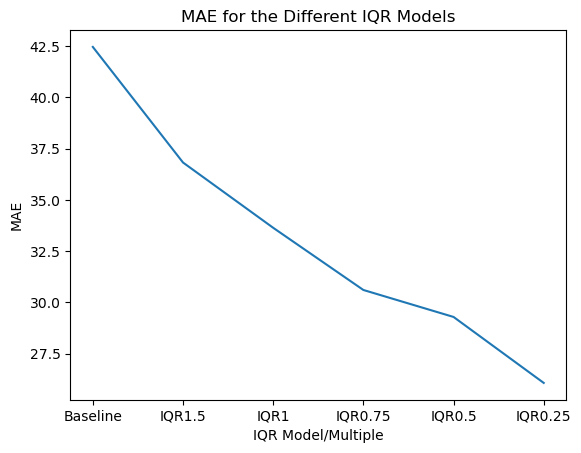

In [13]:
plt.plot(metrics.Variant,metrics.MAE)
plt.title('MAE for the Different IQR Models')
plt.xlabel('IQR Model/Multiple')
plt.ylabel('MAE')
plt.show()

<b> I am going to pick the IQR with a multiplier of 0.25, as it has a lot less error and I see a steep drop the the MAE for the Different Models plot at IQR 0.25 </b>


As expected, the smaller we make the IQR band, the better our model gets. 

In [14]:
# Find the mean sales value for this subset of the data. Interestingly, it is much lower, as the mean value is about 80 for the
# full dataset.

print('Mean Sales Value: ',IQR_025_data['total_sales_value'].mean())

Mean Sales Value:  57.898932498520395


## 4.6 XGBoost model on 0.25 IQR Subset of the Data <a id='4.6'></a>

Now I have selected my dataset to develop a model upon. 

<b> Define a function to run and evaluate each model variant:</b>

In [15]:
# Already defined cols_to_drop and target_col earlier

# Create a dataframe to store metrics in
model_metrics = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2'])

def run_and_evaluate_model(data, model_name, cols_to_drop, target_col, hyper_params=None):
    global model_metrics
    
    X = data.drop(columns=cols_to_drop, axis=1)
    y = data[target_col]
    
    model = xgb.XGBRegressor(**hyper_params) if hyper_params else xgb.XGBRegressor()
    model.fit(X, y)
    
    model.save_model(f"{model_name}.model")

    y_pred = model.predict(X)
    
    # Calculate Metrics
    MAE = round(mean_absolute_error(y, y_pred), 2)
    RMSE = round(mean_squared_error(y, y_pred, squared=False), 2)
    R2 = round(r2_score(y, y_pred), 2)
    
    # Append to DataFrame
    new_metrics = pd.DataFrame({'Model': [model_name], 'MAE': [MAE], 'RMSE': [RMSE], 'R2': [R2]})
    model_metrics = pd.concat([model_metrics, new_metrics], ignore_index=True)
    
    return model


### IQR_025 baseline model

First, I will run an XGBoost model on IQR_025 with no hyperparameter tuning. I am assessing primarily by MAE, as that gives me an interpretable error, given that the means sales value for this data subset is $57.9. 

In [16]:
IQR_025 = run_and_evaluate_model(IQR_025_data, 'IQR_025', cols_to_drop, target_col)

In [17]:
model_metrics

,Model,MAE,RMSE,R2
0,IQR_025,25.61,31.15,0.21


<b> Cross Validation </b>

In [18]:
# Perform cross-validation
scores = cross_val_score(IQR_025, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the mean and standard deviation of the scores
print(f'Mean CV MAE: {scores.mean()}')
print(f'Standard Deviation of CV MAE: {scores.std()}')

Mean CV MAE: -55.04143901385005
Standard Deviation of CV MAE: 2.5705599403262873


The MAE is a bit higher, but it's pretty close, so there's not much overfitting happening here. This is significantly better than the original baseline model at the beginning of the notebook, where the mean CV MAE was 55.

### Hyper parameter tuning

Can I improve upon the model?

In [19]:
X = IQR_025_data.drop(columns=['household_key', 'week_no', 'total_sales_value'], axis=1)
y = IQR_025_data['total_sales_value']

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 4, 5, 8],
    'n_estimators': [50, 100, 150, 200],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_model = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error')

grid_search.fit(X, y)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Use the best model to make predictions
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best Score: -29.07280052387344


In [20]:
# re-run model with these parameters

hyper_params = {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
IQR_025_tuned = run_and_evaluate_model(IQR_025_data, 'IQR_025_tuned', cols_to_drop, target_col, hyper_params)

model_metrics

,Model,MAE,RMSE,R2
0,IQR_025,25.61,31.15,0.21
1,IQR_025_tuned,27.96,34.25,0.05


<b>Cross Validation</b>

In [21]:
# Perform cross-validation
scores = cross_val_score(IQR_025_tuned, X, y, cv=5, scoring='neg_mean_absolute_error')

# Print the mean and standard deviation of the scores
print(f'Mean MAE: {scores.mean()}')
print(f'Standard Deviation of MAE: {scores.std()}')

Mean MAE: -29.07280052387344
Standard Deviation of MAE: 0.5895808126600273


<b> The tuned model has a better cross validation MAE score, and less difference between the model score and the cv score, so I will use this model. It will most likely generalize better to new data. </b>

<b> SELECTED MODEL: IQR_025_tuned</b>

### 4.6.1  Run model on entire data set  <a id='4.6.1'></a>

Now I would like to run my model on my entire dataset, instead of the IQR=0.25 subset. 

In [22]:
# original dataframe: data

X_whole = data.drop(['household_key','week_no','total_sales_value'],axis=1)
y_whole = data['total_sales_value']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_whole, y_whole, test_size=0.1, random_state=42)

# Train the model on the training data
IQR_025_tuned.fit(X_train_w, y_train_w)

# Make predictions on the testing data
y_pred_whole = IQR_025_tuned.predict(X_test_w)

# Evaluate the model's performance
mae_whole = mean_absolute_error(y_test_w, y_pred_whole)
print('Mean Absolute Error:', mae_whole)

# Perform cross-validation
scores = cross_val_score(IQR_025_tuned, X_whole, y_whole, cv=5, scoring='neg_mean_absolute_error')

# Print the mean and standard deviation of the scores
print(f'Mean CV MAE : {scores.mean()}')
print(f'Standard Deviation of CV MAE: {scores.std()}')


Mean Absolute Error: 45.92619512188228
Mean CV MAE : -50.68004523787965
Standard Deviation of CV MAE: 3.287087968166429


<b>Discussion</b> 

When running the model on the entire dataset, the MAE is definitely worse, but it is better than or baseline model from the beginning of this notebook. However, as the goal is the determine the directionality of how features contribute to sales, this is sufficient to continue. 

## 4.7 SHAP ANALYSIS  <a id='4.7'></a>

Now I will perform SHAP analysis on the selected model so that I can determine which features contribute to higher sales vales. 

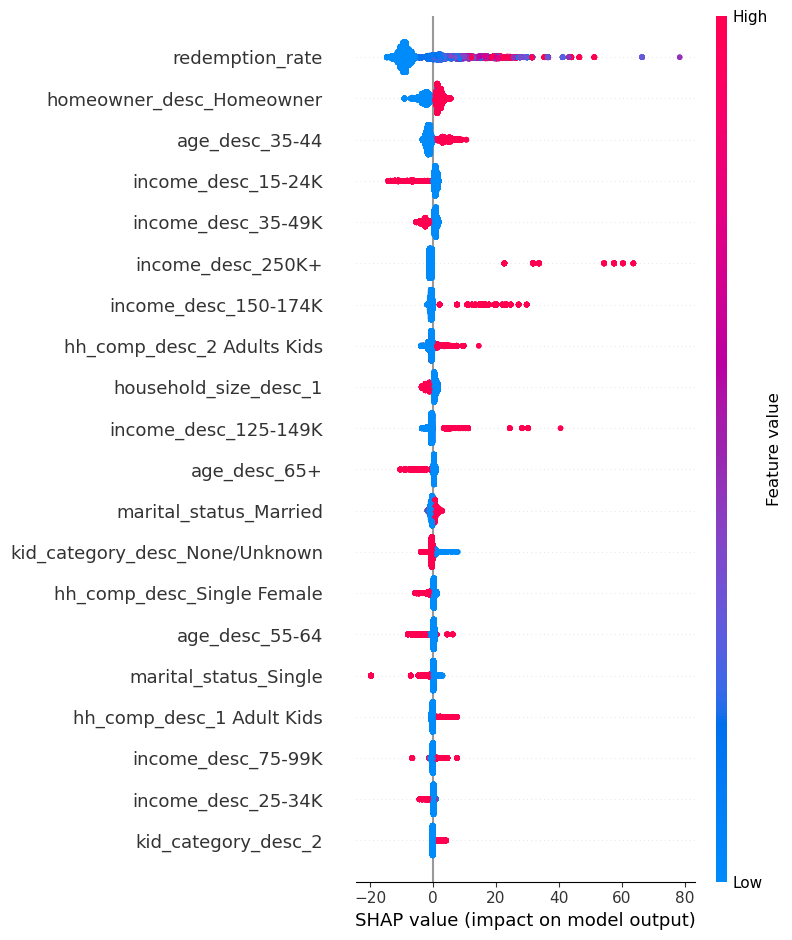

In [23]:
explainer = shap.Explainer(IQR_025_tuned)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)


I definitely see patterns in how feature value is related to the SHAP value.

Below I will rank feature importance by the mean absolute SHAP value, and then plot feature importance for the top features. 

In [24]:
# Ranking Feature Importance- this is another way to look at the data in the plot above: 


# Create a TreeExplainer with parallel processing
explainer = shap.TreeExplainer(IQR_025_tuned, n_jobs=10)

# Compute SHAP values
shap_values = explainer.shap_values(X)

# Calculate the mean absolute SHAP value for each feature
feature_importance = np.mean(np.abs(shap_values), axis=0)

# Get the names of the features from the column names of the dataset
feature_names = X.columns

# Create a DataFrame of the feature names and importance
importance_df = pd.DataFrame(list(zip(feature_names, feature_importance)), 
                              columns=['Feature','Importance'])

# Sort the DataFrame in descending order of importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Filter for importance values greater than 0
importance_df = importance_df[importance_df['Importance'] > 0]

# Display the top 30 features
importance_df.head(30)


,Feature,Importance
0,redemption_rate,9.422806
22,homeowner_desc_Homeowner,2.124747
3,age_desc_35-44,2.121340
12,income_desc_15-24K,1.584218
18,income_desc_35-49K,1.168265
17,income_desc_250K+,1.130409
13,income_desc_150-174K,1.106968
28,hh_comp_desc_2 Adults Kids,1.063733
33,household_size_desc_1,0.914073
11,income_desc_125-149K,0.780404


<b> SHAP dependence plots for top 20 features: </b>

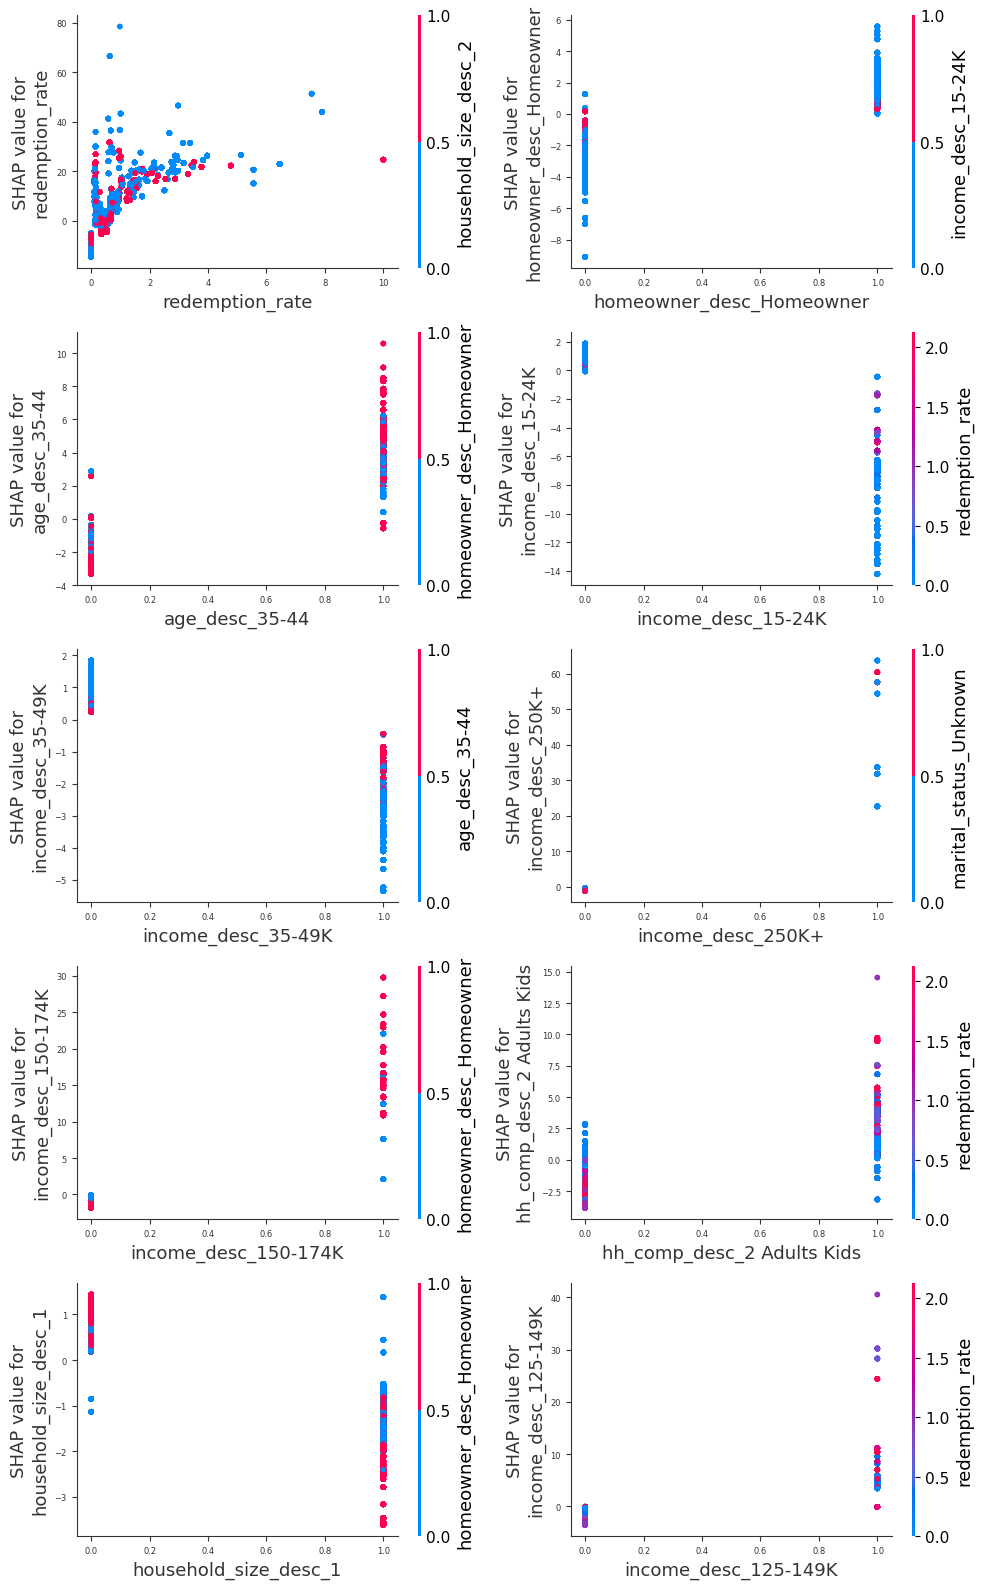

In [25]:
# Divide up our features into 2 code blocks to avoid formatting issues:

# Get the top 10 features from importance_df
top_features_1_10 = importance_df['Feature'].head(10)

# Create a grid of subplots: 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the top 10 features and create a SHAP dependence plot for each on its respective subplot
for i, feature in enumerate(top_features_1_10):
    shap.dependence_plot(feature, shap_values, X, ax=axes[i], show=False)
    axes[i].tick_params(axis='both', which='major', labelsize=6)  # Adjust fontsize of axis labels

# Adjust layout and spacing between subplots
plt.tight_layout()


plt.show();



<b> Discussion</b> 

Higher redemption rates are generally associated with higher SHAP values, although redemption rates over 2% plateau between 5-10.

The 35-49K and 15-24K income brackets have negative SHAP values, and homeowners in these income groups have among the lowest SHAP values. 

Homeowners who earn over 24K a year have positive SHAP values.

The majority of married people have positive SHAP values, and people earning 125-149K a year have among the highest SHAP values among married people.

Most 2 person households have positive SHAP values, and these households who earn 125-149K a year have higher SHAP values. 

1 person households mostly have negative SHAP values, especially if they are homeowners. 

Customers 65+ years old have negative SHAP values, especially if they have incomes 15-24K. 

Single females have mostly negative SHAP values, and strangely higher SHAP values are associated with lower coupon redemption rates. However, people who are not single females have largely positive SHAP values, especially for high redemption rates. 

There were not many customers with incomes of 250K+, but they had the highest SHAP values of all. They do not use coupons, however. I would focus on maintaining these customers, and investigate which marketing campaigns they are responding to (such as mailers or in store displays) as it isn't the mailed coupon campaigns. 

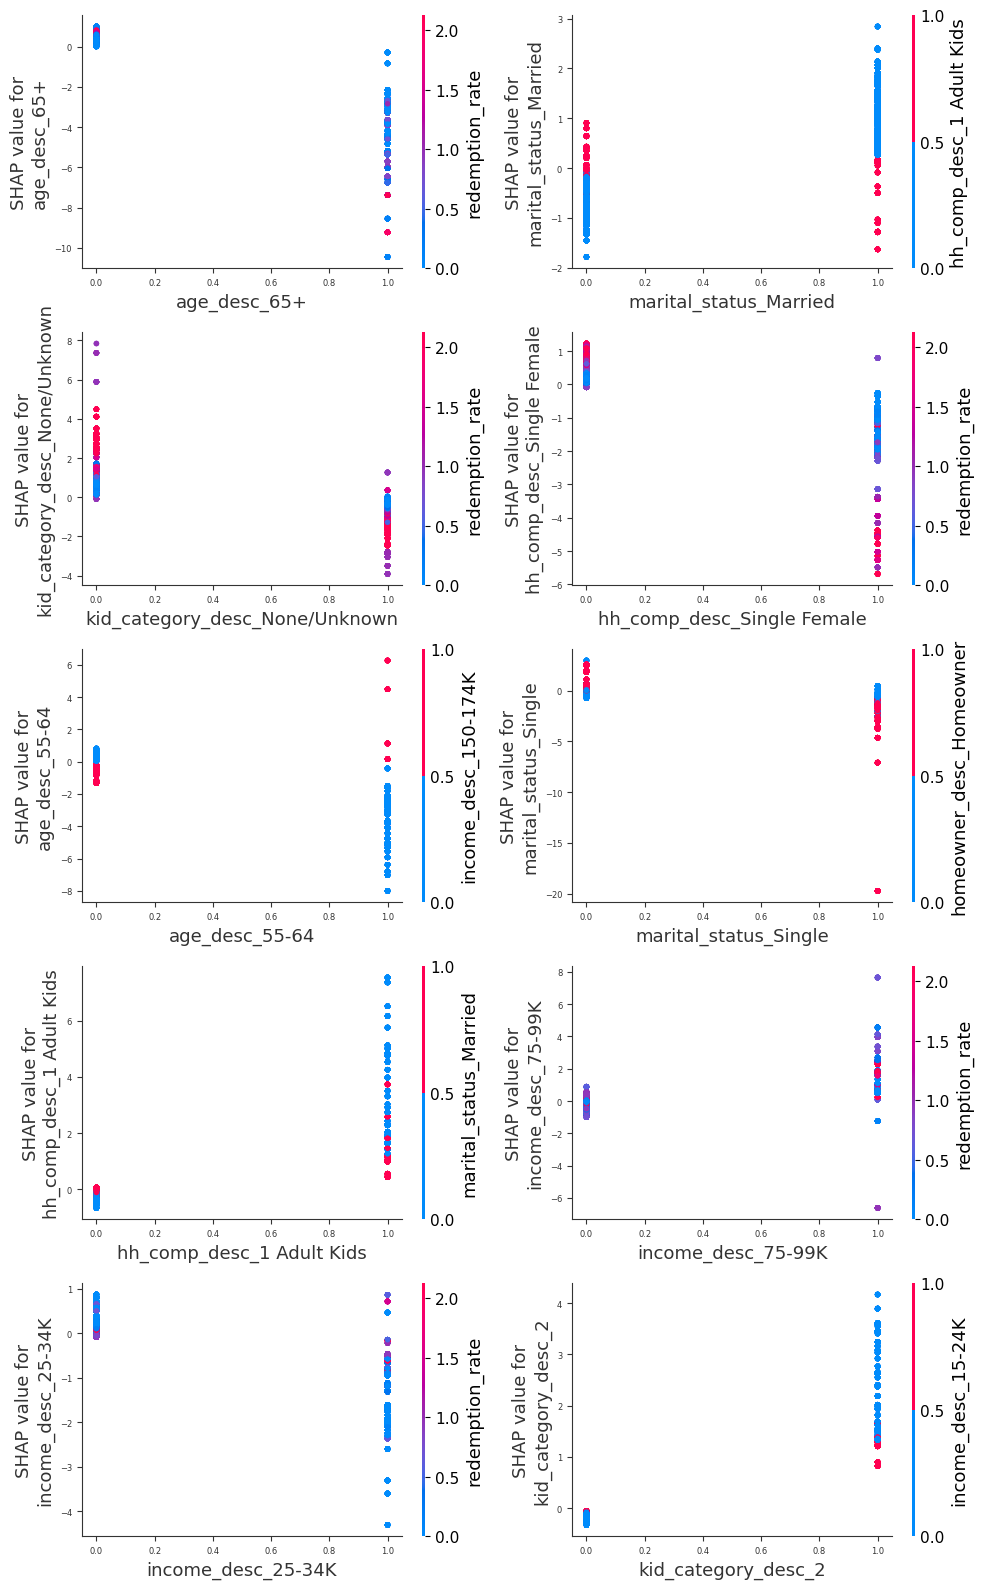

In [26]:
# Next 10 dependence plots: 

# Get features 11-20 from importance_df
top_features_11_20 = importance_df['Feature'][10:20]

# Create a grid of subplots: 
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,16))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through features 11-20 and create a SHAP dependence plot for each on its respective subplot
for i, feature in enumerate(top_features_11_20):
    shap.dependence_plot(feature, shap_values, X, ax=axes[i], show=False)
    axes[i].tick_params(axis='both', which='major', labelsize=6)  # Adjust fontsize of axis labels

plt.tight_layout()

plt.show()


<b>Discussion</b>

Ages 55-64 had negative SHAP values, but married people in this age bracket had values closer to 0.

35-44 year olds mostly had positive SHAP values, particularly if they earn 35-49K a year. 

Customers who make 150-174K had high SHAP values. Most of these customers are also homeowners, and the homeowners had the highest SHAP values. 

Households that are made up of 2 adults and kids mostly had postive SHAP vales, but single adults from these households had negative SHAP values. 

'Unknown' homeowners had mostly negative SHAP valus. This is unexpected as they have higher coupon redemption rates, as we say in the EDA section of this project.

households with an income of 75-99K had postive SHAP values, in particuarly if there were more than 1 person in a household. 

Single people had negative SHAP values.

Households composed of 1 adult and kids had postive SHAP values, and the values were higher for those who earn 35-49K a year.

'Unknown' marital status with redeption rates over 1 had postive SHAP values.

Households earning 125-149K a year had postive SHAP values, and the highest values were for 2 person households.

## 4.8 Conclusions  <a id='4.8'></a>

In this notebook I picked a 25% IQR subset of the full dataset of weekly sales values and demographics for customers, and built an XGBoost regression model upon it to predict customer spending. Because of the variation in the data likely due to exernal factors not considered in the model, seasonality and multicollinearity, I was not able to build a model that could accurately predict spending, but I was able to use SHAP analysis to identify features and interactions of features which contribute towards customer spending. These features can now be used, in combination with the next notebook's results on features that contribute towards coupon use, to develop campaigns which will result in both higher coupon redemption rates and higher sales values. 

<b>Features that contribute towards higher sales:</b>
* Higher redemption rates
* Homeowners earning over 24K a year
* 2 person households consisting of a married couple, especially if they earn 
* 35-44 year olds, especially if they earn 35-49K a year
* 75-99K a year
* 125-174K a year
* 250K+ a year
* 2 person households with kids who are not single
* Households composed of 1 adult and children, especially if they earn 35-49K a year
* 'Unknown' marital status with redemption rates over 1

<b>Features that contribute towards lower sales:</b>
* 15-24K income, especially if they are homeowners
* 35-49K income, especially if they are homeowners (except 35-44 year olds and single parents)
* 1 person households/single people, especially if they are homeowners and/or females
* Customers who are 55+
* 'Unknown' homeowners



<b>Future work:</b>

I would like to investigate redemption rates for the features with positive SHAP values for this model to see if I can find any patterns that could help develop a targeted campaign towards high spenders who use coupons. 

It would also be wise to do further feature engineering to attempt to reduce multicollinearity. For example,this dataset tracks single females, 1 person households, and 1 person households with kids, and there is likely a lot of overlap here. Likewise, 2 person households and married people are likely the same. 

## 4.9 Next Steps  <a id='4.9'></a>

In the next notebook, '5 Dunnhumby Coupon Use Prediction Model', I will build an XGBoost Classification model to predict if a customer will use coupons or not based on their demographics, and I will do SHAP analysis to determine how the features contribute towards coupon use.

## 4.10 Export Model  <a id='4.10'></a>

In [27]:
sales_prediction_model = IQR_025_tuned

# Save the trained model as a pickle string
with open('sales_prediction_model.pkl', 'wb') as f:
    pickle.dump(sales_prediction_model, f)
